Eighth exercice: MR image reconstruction from Cartesian data
==============================================

In this tutorial we will reconstruct an MR image from Cartesian under-sampled kspace measurements.

We use the toy datasets available in pysap, more specifically a 2D brain slice
and the cartesian acquisition scheme.
We compare zero-order image reconstruction with Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation.Sparsity will be promoted in the wavelet domain, using either Symmlet-8 (analysis and synthesis) or undecimated bi-orthogonal wavelets (analysis only).

We remind that the synthesis formulation reads (minimization in the sparsifying domain):
$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \|y - \Omega F \Psi^*z \|_2^2 + \lambda \|z\|_1
$$
and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \|y - \Omega F x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021 
- Target: ATSI MSc students, Paris-Saclay University

In [13]:
# Package import
from mri.operators import FFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
from pysap.data import get_sample_data

# Third party import
from modopt.opt.proximity import SparseThreshold
from modopt.opt.linear import Identity
from modopt.math.metrics import ssim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = get_sample_data('2d-mri')
# Obtain K-Space Cartesian Mask
mask = get_sample_data("cartesian-mri-mask")

[====================] 100% example_mri_ref_image_2d.npy            
Download was done in 0 minutes,  2.49 seconds
[====================] 100% example_mri_cartesian_mask_2d.npy       
Download was done in 0 minutes,  1.68 seconds


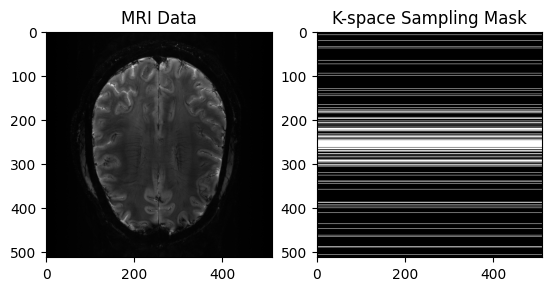

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask.
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [4]:
# Get the locations of the kspace samples
kspace_loc = convert_mask_to_locations(mask.data)
# Generate the subsampled kspace
fourier_op = FFT(samples=kspace_loc, shape=image.shape)
kspace_data = fourier_op.op(image)

Zero order solution

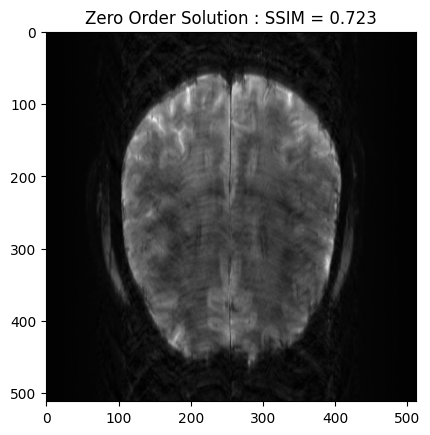

In [5]:
zero_soln = fourier_op.adj_op(kspace_data)
base_ssim = ssim(zero_soln, image)
plt.imshow(np.abs(zero_soln), cmap='gray')
plt.title('Zero Order Solution : SSIM = ' + str(np.around(base_ssim, 3)))
plt.show()

Synthesis formulation: FISTA vs POGM optimization
------------------------------------------------------------

We now want to refine the zero-order solution using compressed sensing reconstruction.
Here we adopt the synthesis formulation based on the FISTA algorithm.
The cost function is set to Proximity Cost + Gradient Cost

In [7]:
# Setup the operators
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")
# Setup Reconstructor
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.0999999714598445
The lipschitz constraint is satisfied


 - mu:  2e-07
 - lipschitz constant:  1.0999999714598445
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fd8fb9fa980> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  28.364572323858738  seconds
----------------------------------------


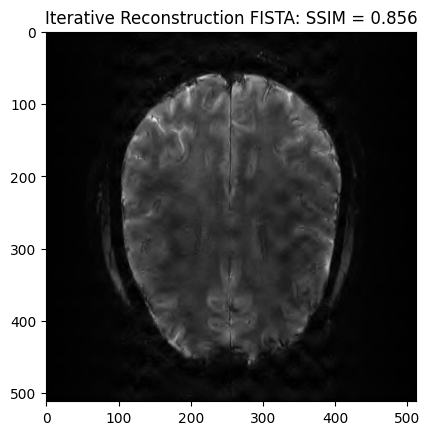

In [10]:
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='fista',
    num_iterations=200,
)
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Iterative Reconstruction FISTA: SSIM = ' + str(np.around(recon_ssim, 3)))
plt.show()

## POGM optimization 

 - mu:  2e-07
 - lipschitz constant:  1.0999999714598445
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fd8fb9fa980> - 4
 - max iterations:  200
 - image variable shape:  (1, 512, 512)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  84.0406078863889  seconds
----------------------------------------


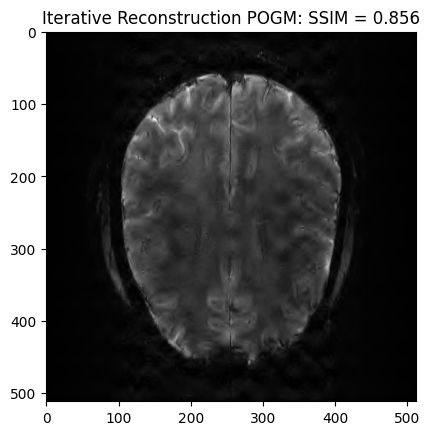

In [11]:
image_rec2, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='pogm',
    num_iterations=200,
)
recon2_ssim = ssim(image_rec2, image)
plt.imshow(np.abs(image_rec2), cmap='gray')
plt.title('Iterative Reconstruction POGM: SSIM = ' + str(np.around(recon2_ssim, 3)))
plt.show()

Analysis formulation: Condat-Vu reconstruction 
---------------------------------------------------------------------

In [24]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")

In [29]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 1.1000000061686157
The lipschitz constraint is satisfied


In [27]:
image_rec3, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='condatvu',
    num_iterations=200,
)
recon3_ssim = ssim(image_rec3, image)
plt.imshow(np.abs(image_rec3), cmap='gray')
plt.title('Iterative Reconstruction Condat-Vu: SSIM = ' + str(np.around(recon3_ssim, 3)))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './mr_temp_2024.01.30_16.27.25156421587793685017194437779219277058618.mr'